In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np 
import warnings
import glob 
import os 

# Make NumPy printouts easier to read.
np.set_printoptions(precision=5, suppress=True)
warnings.filterwarnings("ignore")

print(tf.__version__)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [10]:
def custom_scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


def build_and_compile_model_input(k):
      model = tf.keras.models.Sequential([
          tf.keras.layers.Dense(512, activation='relu', input_shape=(k,)),
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(1,activation='linear') 
    ])

      model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                    loss="mse",
                    metrics=['mae'])
      return model

scheduler = LearningRateScheduler(custom_scheduler)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)
callbacks = [scheduler, tensorboard]

EPOCHS = 60
BATCH_SIZE=64

DATASET_CALOSC=pd.read_csv('../Dane/data_nowe/dane_przetworzone/12_wybranych_nowy_parametr/calosc/calosc.csv')
DATASET_CALOSC_MAX=DATASET_CALOSC['Tyg_zuzycie'].max()
DATASET_CALOSC['Tyg_zuzycie'] = (DATASET_CALOSC['Tyg_zuzycie']) / (DATASET_CALOSC['Tyg_zuzycie'].max())


In [ ]:
input_3_plot=np.arange(0,1,1/1440) 
input_3=np.vstack((2*np.ones_like(input_3_plot, dtype=int),2*np.ones_like(input_3_plot, dtype=int),input_3_plot)).T

In [ ]:
DATASET_CALOSC

# model 3 input

In [ ]:
dataset = DATASET_CALOSC
dataset=dataset.drop(columns="Tyg_zuzycie")
x=dataset.drop(columns="Przeplyw")
y=dataset.drop(columns="Dzien_tygodnia")
y=y.drop(columns="Czas_dnia")
y=y.drop(columns="Pora_roku")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model_calosc_danych_bez_dodatku =build_and_compile_model_input(3)
model_calosc_danych_bez_dodatku.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)
model_calosc_danych_bez_dodatku.save("../Modele/11_12_testowanie/model_calosc_bez_dodatku")

In [ ]:
xplot=flow_time_plot=np.arange(0,24,24/1440) 

In [ ]:
flow_time_plot=np.arange(0,1,1/1440) 
flow_time=np.vstack((1*np.ones_like(flow_time_plot, dtype=int),(1*np.ones_like(flow_time_plot, dtype=int)),flow_time_plot)).T
flow_result = model_calosc_danych_bez_dodatku.predict(flow_time)

plt.plot(xplot, flow_result)
plt.xlabel('Czas dnia, h')
plt.ylabel('Przepływ, l/min')

# model 4 input

In [ ]:
dataset = DATASET_CALOSC
x=dataset.drop(columns="Przeplyw")
y=dataset.drop(columns="Dzien_tygodnia")
y=y.drop(columns="Czas_dnia")
y=y.drop(columns="Tyg_zuzycie")
y=y.drop(columns="Pora_roku")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model_calosc_danych_z_dodatku =build_and_compile_model_input(4)
model_calosc_danych_z_dodatku.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)
model_calosc_danych_z_dodatku.save("../Modele/11_12_testowanie/model_calosc_z_dodatku")

In [ ]:
flow_time_plot=np.arange(0,1,1/1440) 

result = dataset.loc[(dataset['Dzien_tygodnia'] == 1) & (dataset['Pora_roku'] == 1),"Tyg_zuzycie"]
flow_time=np.vstack((1*np.ones_like(flow_time_plot, dtype=int),(1*np.ones_like(flow_time_plot, dtype=int)),flow_time_plot,result.mean()*np.ones_like(flow_time_plot, dtype=int))).T
flow_result = model_calosc_danych_z_dodatku.predict(flow_time)

plt.plot(xplot, flow_result)
plt.xlabel('Czas dnia, h')
plt.ylabel('Przepływ, l/min')

# Porównanie

In [ ]:
def prep_data(data):
    data=data.drop(columns="Tyg_zuzycie")
    data['Czas_dnia'] = data['Czas_dnia'] 
    x=data.drop(columns="Przeplyw")
    y=data.drop(columns="Dzien_tygodnia")
    y=y.drop(columns="Czas_dnia")
    y=y.drop(columns="Pora_roku")
    return [x,y]

In [ ]:
mse_matrix=np.array([
    [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
])
fig_1, axs_1 = plt.subplots(2, 6,figsize=(28, 12))
fig_1.suptitle('Wyniki Modelu Ogólnego i Szczegółowego')

fig_3, axs_3 = plt.subplots(2, 6,figsize=(28, 12))
fig_3.suptitle('Wyniki Modelu Ogólnego i Szczegółowego')

path = os.getcwd() 
csv_files = glob.glob(os.path.join(path, '../Dane/data_nowe/dane_przetworzone/12_wybranych_nowy_parametr/*.csv')) 
i=0;
k=0;
model_number=0
for f in csv_files: 
    dataset = pd.read_csv(f) 
    dataset['Tyg_zuzycie'] = (dataset['Tyg_zuzycie']) / (DATASET_CALOSC_MAX)
    [x,y]=prep_data(dataset) 

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    model_temp =build_and_compile_model_input(3)
    model_temp.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)
    model_temp.save("../Modele/11_12_testowanie/szczegółowe/model_calosc_z_dodatku_"+str(model_number))
    
    input_3=np.vstack((2*np.ones_like(flow_time_plot, dtype=int),(2*np.ones_like(flow_time_plot, dtype=int), flow_time_plot))).T

    output_1=model_temp.predict(input_3)
    axs_1[k,i].plot(xplot, output_1.reshape(1440),label='Model szczególny')
    output_2=model_calosc_danych_bez_dodatku.predict(input_3)
    axs_1[k,i].plot(xplot, output_2.reshape(1440),label='Model ogólny')
    axs_1[k,i].set_xlabel('Czas dnia, h')
    axs_1[k,i].set_ylabel('Przepływ, l/m')
    axs_1[k,i].set_xlim(0, 24)
    mse=mean_squared_error(output_1,output_2)
    axs_1[k,i].set_title("Dom: "+ str(model_number+1))
    axs_1[k,i].legend()

    mse_matrix[0, model_number]=mse

    result = dataset.loc[(dataset['Dzien_tygodnia'] == 2) & (dataset['Pora_roku'] == 2),"Tyg_zuzycie"]
    input_4=np.vstack((2*np.ones_like(flow_time_plot, dtype=int), 2*np.ones_like(flow_time_plot, dtype=int), flow_time_plot, result.mean()*np.ones_like(flow_time_plot, dtype=int))).T
    axs_3[k,i].plot(xplot, output_1.reshape(1440),label='Model szczególny')
    output_4=model_calosc_danych_z_dodatku.predict(input_4)
    axs_3[k,i].plot(xplot, output_4.reshape(1440),label='Model ogolny')
    axs_3[k,i].set_xlabel('Czas dnia, h')
    axs_3[k,i].set_ylabel('Przepływ, l/m')
    axs_3[k,i].set_xlim(0, 24)
    mse=mean_squared_error(output_1,output_4)
    axs_3[k,i].set_title("Dom: "+str(model_number+1))
    axs_3[k,i].legend()

    mse_matrix[1, model_number]=mse

    i+=1
    model_number+=1
    if i==6:
        k=1
        i=0

plt.tight_layout()

plt.show()


In [17]:
model_bez= tf.keras.models.load_model("../Modele/11_12_testowanie/model_calosc_bez_dodatku")
model_z= tf.keras.models.load_model("../Modele/11_12_testowanie/model_calosc_z_dodatku")

model_0= tf.keras.models.load_model("../Modele/11_12_testowanie/szczegółowe/model_calosc_z_dodatku_0/")
model_1= tf.keras.models.load_model("../Modele/11_12_testowanie/szczegółowe/model_calosc_z_dodatku_1/")
model_2= tf.keras.models.load_model("../Modele/11_12_testowanie/szczegółowe/model_calosc_z_dodatku_2/")
model_3= tf.keras.models.load_model("../Modele/11_12_testowanie/szczegółowe/model_calosc_z_dodatku_3/")
model_4= tf.keras.models.load_model("../Modele/11_12_testowanie/szczegółowe/model_calosc_z_dodatku_4/")
model_5= tf.keras.models.load_model("../Modele/11_12_testowanie/szczegółowe/model_calosc_z_dodatku_5/")
model_6= tf.keras.models.load_model("../Modele/11_12_testowanie/szczegółowe/model_calosc_z_dodatku_6/")
model_7= tf.keras.models.load_model("../Modele/11_12_testowanie/szczegółowe/model_calosc_z_dodatku_7/")
model_8= tf.keras.models.load_model("../Modele/11_12_testowanie/szczegółowe/model_calosc_z_dodatku_8/")
model_9= tf.keras.models.load_model("../Modele/11_12_testowanie/szczegółowe/model_calosc_z_dodatku_9/")
model_10= tf.keras.models.load_model("../Modele/11_12_testowanie/szczegółowe/model_calosc_z_dodatku_10/")
model_11= tf.keras.models.load_model("../Modele/11_12_testowanie/szczegółowe/model_calosc_z_dodatku_11/")




In [ ]:
flow_time_plot=np.arange(0,1,1/1440) 
flow_time_PLOT=np.arange(0,24,24/1440) 
input_3=np.vstack((2*np.ones_like(flow_time_plot, dtype=int),(2*np.ones_like(flow_time_plot, dtype=int), flow_time_plot))).T

model_bez_predict=model_bez.predict(input_3)

model_0_predict=model_0.predict(input_3)
model_1_predict=model_1.predict(input_3)
model_2_predict=model_2.predict(input_3)
model_3_predict=model_3.predict(input_3)
model_4_predict=model_4.predict(input_3)
model_5_predict=model_5.predict(input_3)
model_6_predict=model_6.predict(input_3)
model_7_predict=model_7.predict(input_3)
model_8_predict=model_8.predict(input_3)
model_9_predict=model_9.predict(input_3)
model_10_predict=model_10.predict(input_3)
model_11_predict=model_11.predict(input_3)

fig_1, axs_1 = plt.subplots(4, 3,figsize=(28, 24))

wyniki=[]
wyniki.append(model_0_predict)
wyniki.append(model_1_predict)
wyniki.append(model_2_predict)
wyniki.append(model_3_predict)
wyniki.append(model_4_predict)
wyniki.append(model_5_predict)
wyniki.append(model_6_predict)
wyniki.append(model_7_predict)
wyniki.append(model_8_predict)
wyniki.append(model_9_predict)
wyniki.append(model_10_predict)
wyniki.append(model_11_predict)

FONTSIZE=14
k=1
for i in range(4):
    for j in range(3):
        axs_1[i, j].plot(flow_time_PLOT, model_bez_predict,label='Model ogólny',linewidth=2,color='blue')
        axs_1[i, j].plot(flow_time_PLOT, wyniki[k-1],label='Model szczegółowy',linewidth=2,color='red')
        axs_1[i, j].set_title("Domostwo: "+str(k),fontsize=FONTSIZE)
        axs_1[i, j].set_xlabel('Czas, h', fontsize=FONTSIZE)
        axs_1[i, j].set_ylabel('Przepływ, l/m', fontsize=FONTSIZE)
        axs_1[i, j].set_xlim(0, 24)
        axs_1[i, j].legend()
        k=k+1
        

for ax in axs_1.flat:
    ax.tick_params(axis='both', labelsize=FONTSIZE)

45/45 [==============================] - 0s 1ms/step


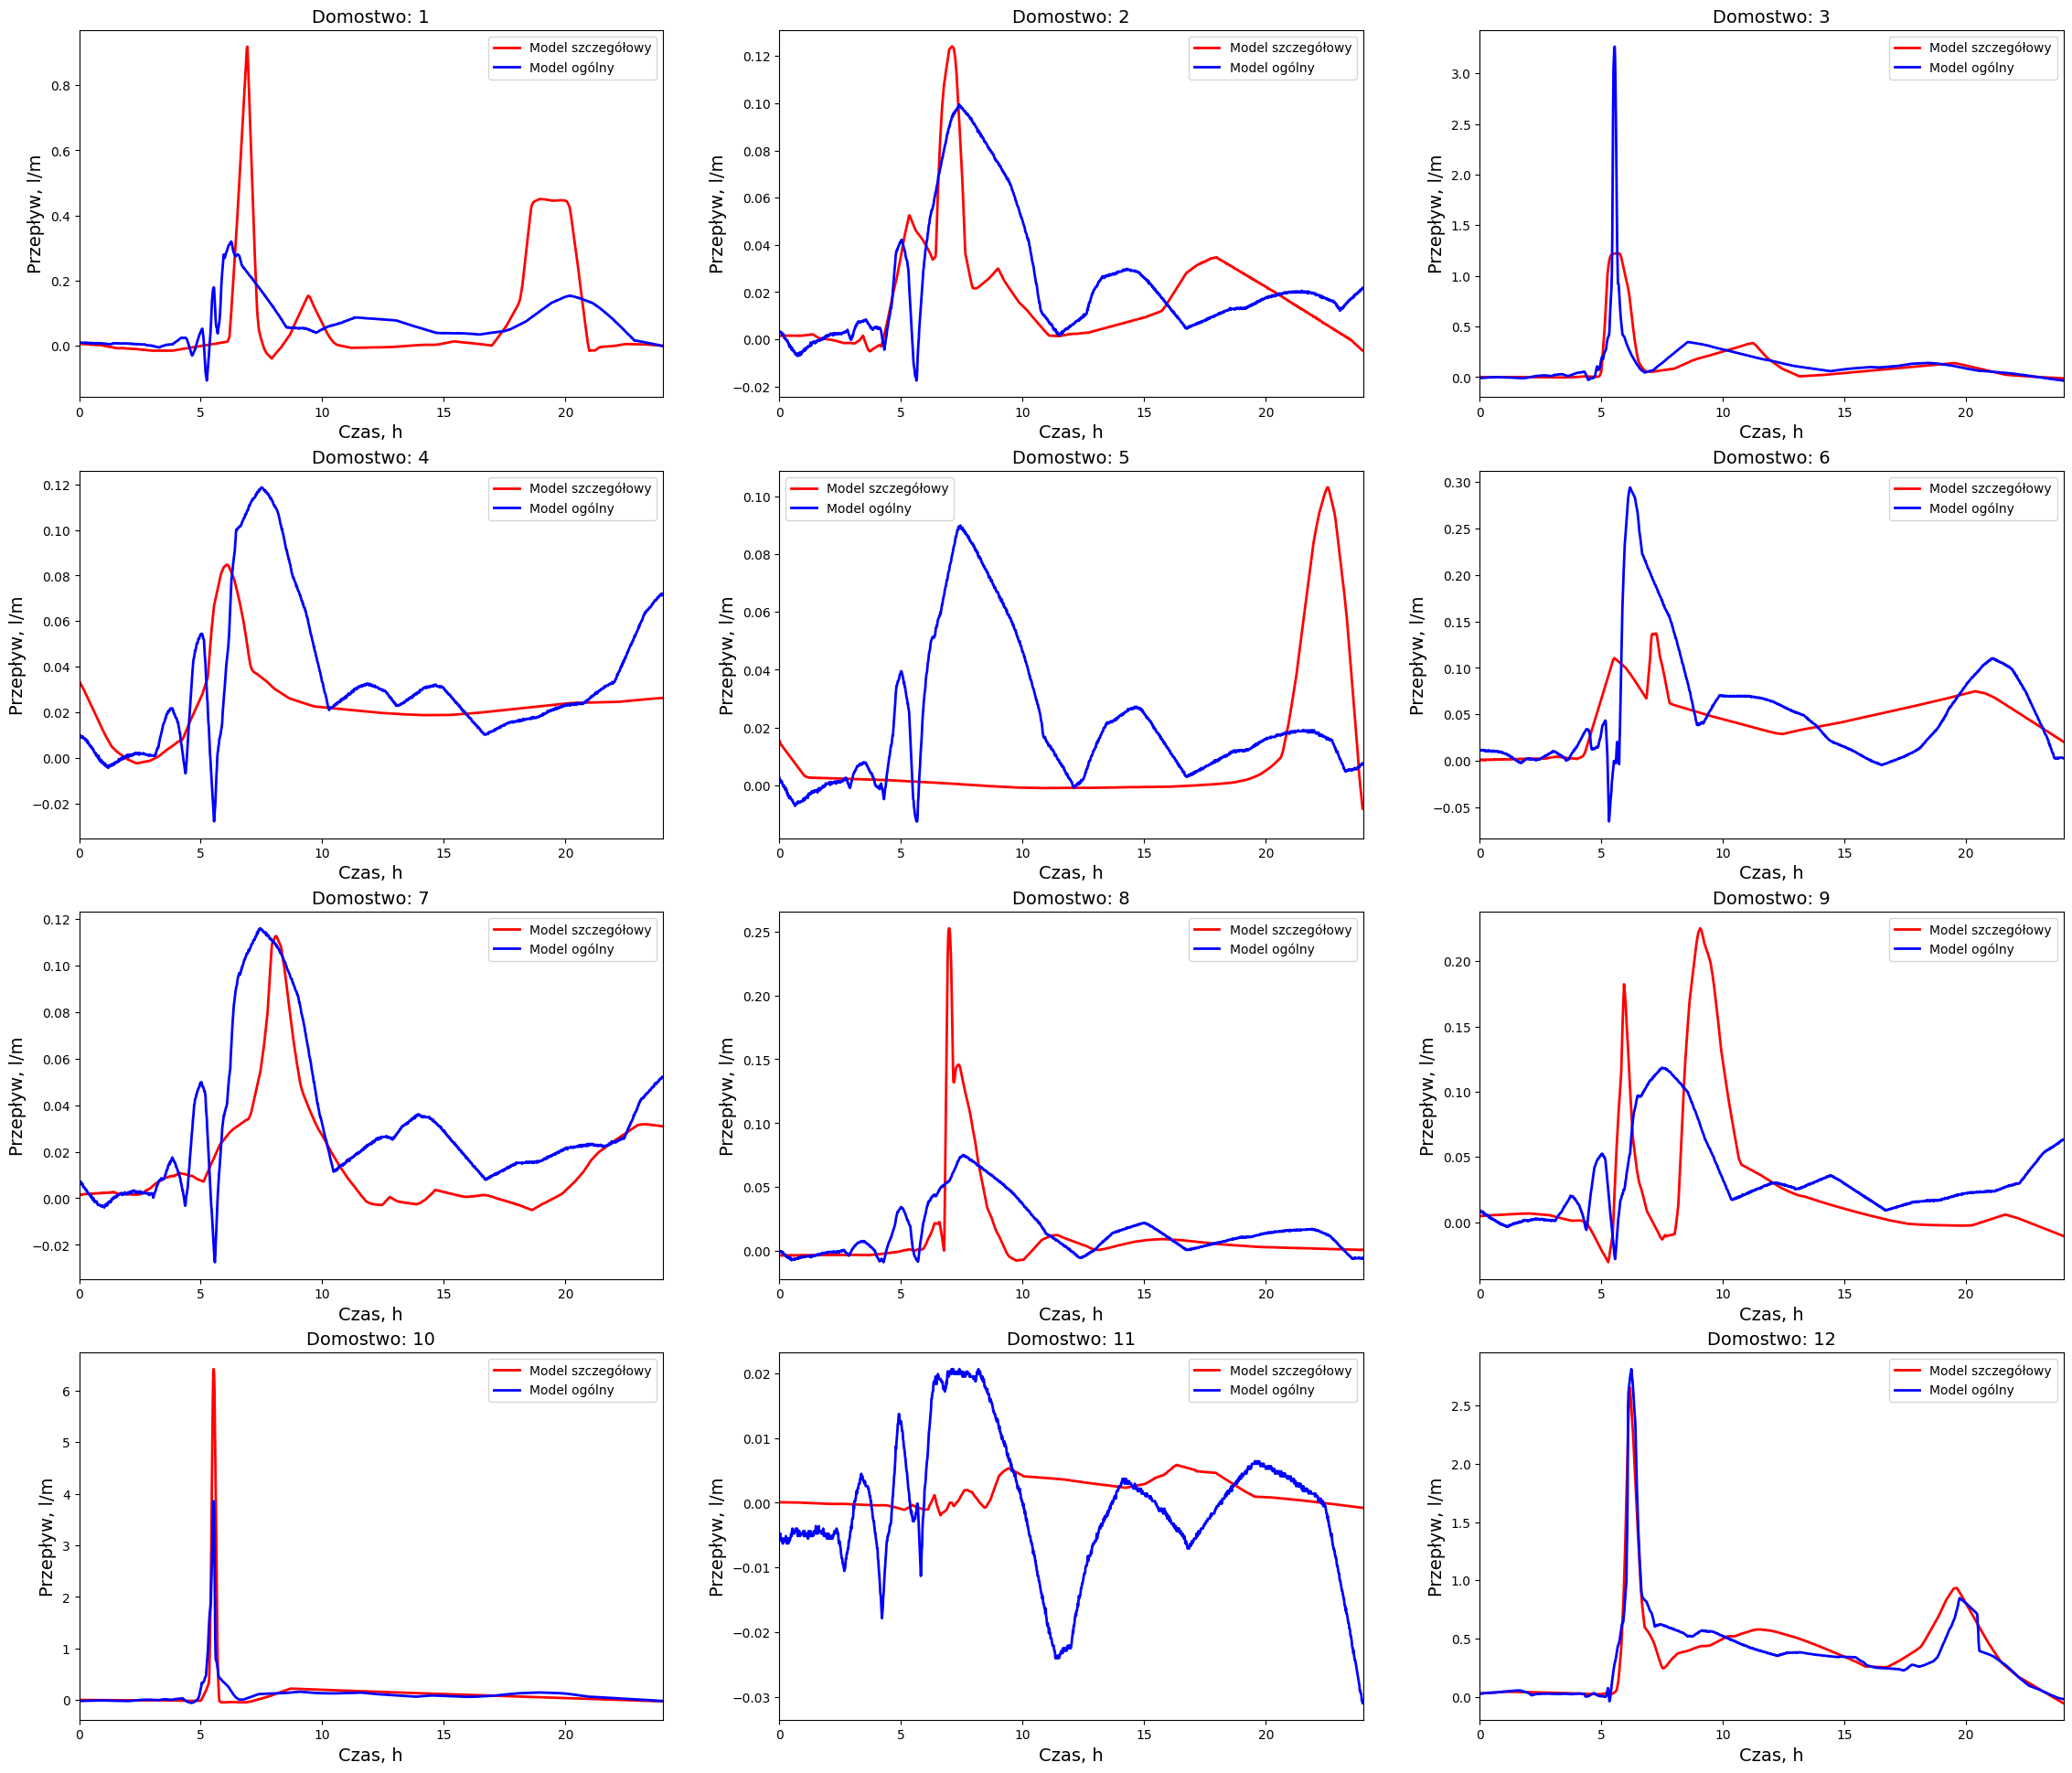

In [18]:

fig_1, axs_1 = plt.subplots(4, 3,figsize=(28, 24))
k=1
path = os.getcwd() 
csv_files = glob.glob(os.path.join(path, '../Dane/data_nowe/dane_przetworzone/12_wybranych_nowy_parametr/*.csv')) 


mean=[]
wyniki.append(model_0_predict)
for f in csv_files: 

    dataset = pd.read_csv(f) 
    dataset['Tyg_zuzycie'] = (dataset['Tyg_zuzycie']) / (DATASET_CALOSC_MAX)
    
    result = dataset.loc[(dataset['Dzien_tygodnia'] == 2) & (dataset['Pora_roku'] == 2),"Tyg_zuzycie"]
    mean.append(result.mean())
mean

for i in range(4):
    for j in range(3):

        axs_1[i, j].plot(flow_time_PLOT, wyniki[k-1],label='Model szczegółowy',linewidth=2,color='red')

        input_4=np.vstack((2*np.ones_like(flow_time_plot, dtype=int), 2*np.ones_like(flow_time_plot, dtype=int), flow_time_plot, mean[k-1]*np.ones_like(flow_time_plot, dtype=int))).T
        wynik=model_z.predict(input_4)

        axs_1[i, j].plot(flow_time_PLOT, wynik,label='Model ogólny',linewidth=2,color='blue')
        
        axs_1[i, j].set_title("Domostwo: "+str(k),fontsize=FONTSIZE)
        axs_1[i, j].set_xlabel('Czas, h', fontsize=FONTSIZE)
        axs_1[i, j].set_ylabel('Przepływ, l/m', fontsize=FONTSIZE)
        axs_1[i, j].set_xlim(0, 24)
        axs_1[i, j].legend()
        k=k+1
        
